In [1]:
import os
import json
import csv
#import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import cycler, patches
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
#from matplotlib.colors import LogNorm

from scipy.optimize import curve_fit

from legendmeta import LegendMetadata
meta_path = '/lfs/l1/legend/users/bianca/sw/legend-metadata'
lmeta = LegendMetadata(path=meta_path)

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
def savefig(figure, detector_name, title):
    path= f'/lfs/l1/legend/users/bianca/PSD_HVscan/plots/{detector_name}/'
    os.makedirs(path, exist_ok=True) 
    figure.savefig(f'{path}/{title}_{detector_name}_HVscan.png',dpi=200, bbox_inches='tight')

In [3]:
def set_limits(values,shift=50):
    values = values[(values>0)]
    if len(values) > 0:
        values_min, values_max, values_mean = np.min(values), np.max(values), np.mean(values)
        if values_min < values_mean - shift:
            lim1 = values_min - shift
        else:
            lim1 = values_mean - shift
        #if lim1 < 0: lim1 = 0
        if values_max > values_mean + shift:
            lim2 = values_max + shift
        else:
            lim2 = values_mean + shift
        return lim1, lim2
    else:
        return -1, 1

In [4]:
def quad_plateau(x, x0, y0, a, b): 
    initial = y0 + a * ( x - x0 )**2 * (x < x0 )
    plateau = y0 + b * (x - x0) * (x > x0)
    return initial+plateau

### Plotting

In [5]:
IPython_default = plt.rcParams.copy()
SMALL_SIZE = 12
MEDIUM_SIZE = 18
LARGE_SIZE = 20

plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=LARGE_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=LARGE_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=LARGE_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=LARGE_SIZE)  # legend fontsize 
plt.rc('figure', titlesize=LARGE_SIZE)  # fontsize of the figure title
plt.rcParams["font.family"] = "serif"

matplotlib.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['legend.title_fontsize'] = 'xx-LARGE'

marker_size = 2
line_width = 0.5
cap_size = 0.5
cap_thick = 0.5

colors = cycler('color', ['tab:blue', 'orange', 'g', 'r', 'm', 'y', 'k', 'c', '#8c564b'])
plt.rc('axes', facecolor='white', edgecolor='black',
       axisbelow=True, grid=False, prop_cycle=colors)

### Settings

In [13]:
save_fig = True
depletion = True
detectors = ['V05261B', 'V05266A', 'V05266B', 'V05268B', 'V05612A', 'V05267B', 'V05261A', 'V05268A', 'V05267A', 'V05612B']
n_det = 3

### Load files

In [14]:
file_path_new = '/lfs/l1/legend/users/bianca/PSD_HVscan/results/'
file_new = f'{file_path_new}/{detectors[n_det]}.json'

file_path_old = '/lfs/l1/legend/users/dandrea/legend-ge-processing/l200-p05/r005/results'
file_old = f'{file_path_old}/l200-p05-r005-hv_scan_{detectors[n_det]}.json'

file_path_Co60 ='/lfs/l1/legend/users/redchuk/hades-char/V05_FWHM_vs_HV'
file_Co60 = f'{file_path_Co60}/{detectors[n_det]}.csv'

In [15]:
file_dict = 'l200-p07-r009-hv_scan.json'
with open(file_dict, "r") as file:
    test_dict = json.load(file)
key_list_file = open(f'l200-p07-r009-tst-key.list', "r")
key_list = key_list_file.read().split('\n')
time_string = key_list[0]
chmap = lmeta.hardware.configuration.channelmaps.on(time_string)
string = int(chmap[detectors[n_det]]['location']['string'])
position = int(chmap[detectors[n_det]]['location']['position'])
operating = float(test_dict[detectors[n_det]]['operating'])
try:
    manufacturer_hv = True
    depletion = float(test_dict[detectors[n_det]]['depletion'])
    reccomended = float(test_dict[detectors[n_det]]['reccomended'])
except:
    manufacturer_hv = False
    pass
print(reccomended)

5000.0


[17418.33007812]
pp_999 3927.726146583703
pp_9999 4700.0


ValueError: operands could not be broadcast together with shapes (9,) (10,) 

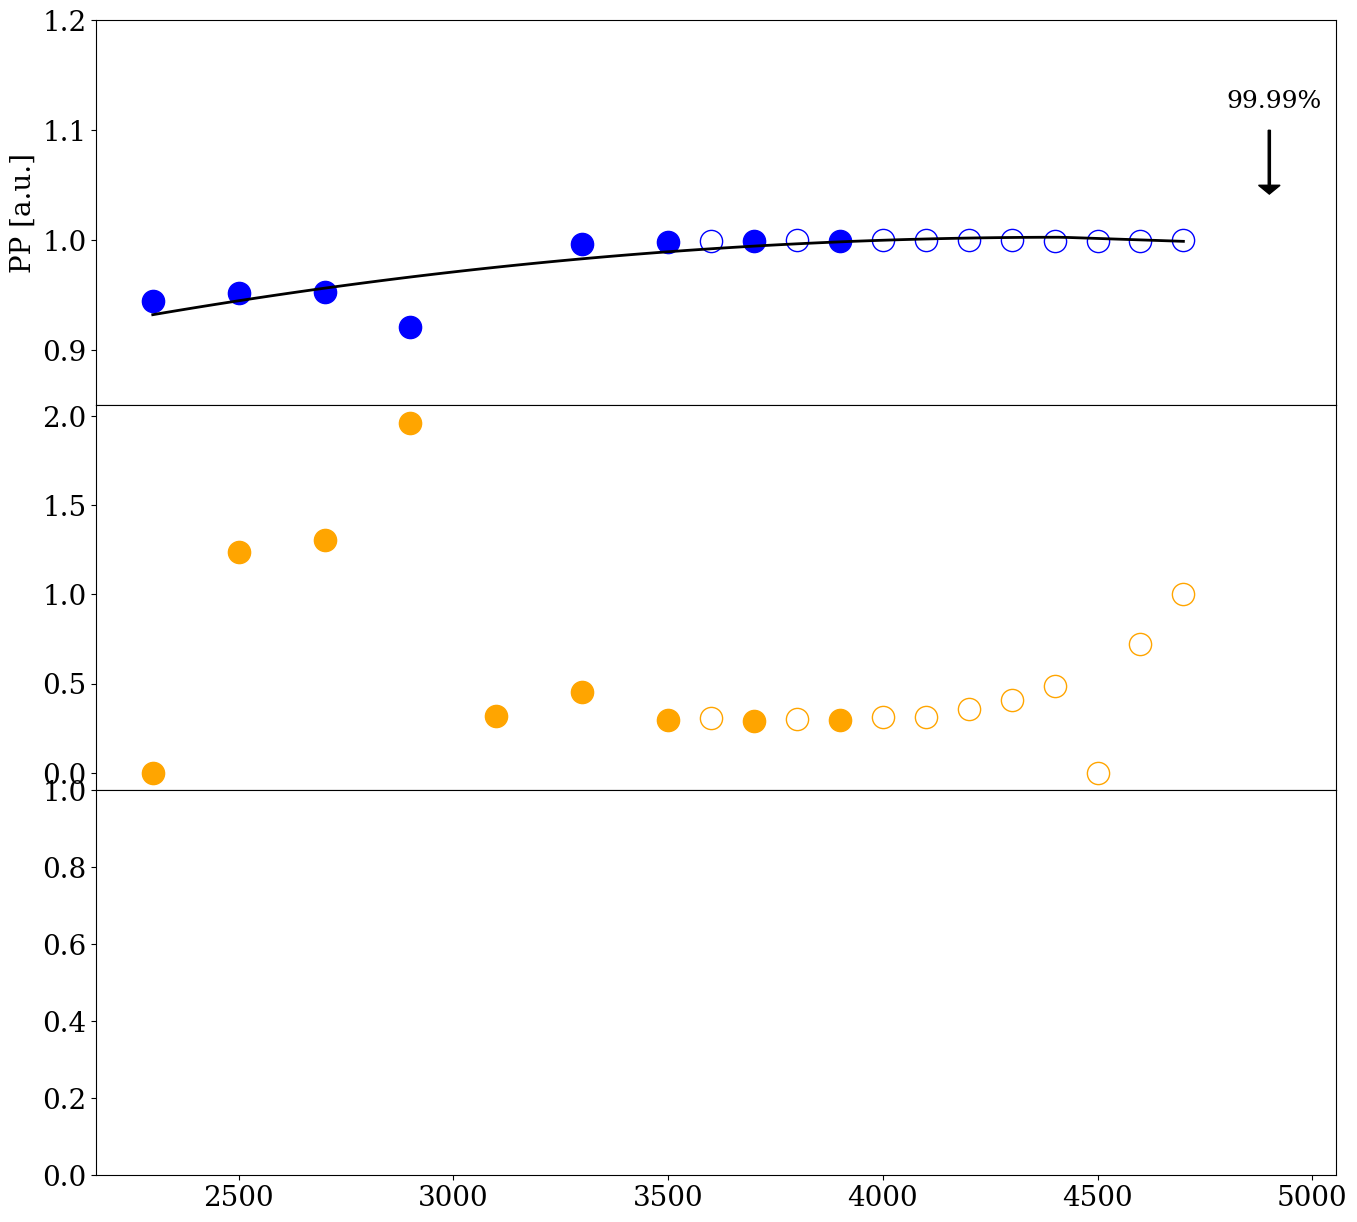

In [46]:
#comparison with new scan
with open(file_new, "r") as outfile: 
    scan_new = json.load(outfile)
    
voltages_new = np.array([int(v) for v in scan_new['voltages']]) 
peak_pos_FEP_new = np.array([float(v) for v in scan_new['peak_pos']]) 
peak_fwhm_FEP_new = np.array([float(v) for v in scan_new['peak_fwhm']]) 
pulser_pos_new = np.array([float(v) for v in scan_new['puls_pos']]) 
discharges_rate_new = np.array([float(v) for v in scan_new['rate_discharges']]) 

'''
#comparison with old scan
with open(file_old, "r") as outfile: 
    scan_old = json.load(outfile)
    
voltages_old = np.array([int(v) for v in scan_old['voltages']]) 
peak_pos_FEP_old = np.array([float(v) for v in scan_old['peak_pos']]) 
peak_fwhm_FEP_old = np.array([float(v) for v in scan_old['peak_fwhm']]) 
pulser_pos_old = np.array([float(v) for v in scan_old['puls_pos']]) 
discharges_rate_old = np.array([float(v) for v in scan_old['rate_discharges']]) 
'''
#compare with Co60 HADES characterization
voltages_Co60 = []
peak_fwhm_Co60 = []

with open(file_Co60, "r") as csv_file: 
    csv_reader = csv.DictReader(csv_file)
    for row in csv_reader:
        voltages_Co60.append(int(row['opV']))
        peak_fwhm_Co60.append(float(row['fwhm_co60fep']))
voltages_Co60=np.array(voltages_Co60)
peak_fwhm_Co60=np.array(peak_fwhm_Co60)

if reccomended in voltages_old :
    best_voltage=reccomended
else:
    best_voltage=max(voltages_old)

best_peak = peak_pos_FEP_old[voltages_old==best_voltage]
best_fwhm = peak_fwhm_FEP_old[voltages_old==best_voltage]
best_fwhm_Co60 = peak_fwhm_Co60[voltages_Co60==reccomended]
print(best_peak)

fig, axis = plt.subplots(3, figsize=(16,15), sharex='col',gridspec_kw={'hspace': 0, 'wspace': 0})

min_voltage=min(list([min(voltages_new), min(voltages_old), min(voltages_Co60)]))
max_voltage=max(list([max(voltages_new), max(voltages_old), max(voltages_Co60)]))

mask_peak_new = (peak_pos_FEP_new>1500) #(peak_pos_FEP>0)#15500)
mask_peak_old = (peak_pos_FEP_old>1500) #(peak_pos_FEP_old>0)#15500)

axis[0].plot(voltages_new[mask_peak_new],peak_pos_FEP_new[mask_peak_new]/best_peak,'b:',marker='o',ms=16,ls='none', label='new scan')
axis[0].plot(voltages_old[mask_peak_old],peak_pos_FEP_old[mask_peak_old]/best_peak,'b:',marker='o',ms=16, ls='none',markerfacecolor='none', label='old scan')
peak_pos_tot = np.array(list(peak_pos_FEP_new[mask_peak_new])+ list(peak_pos_FEP_old[mask_peak_old]))
voltages_tot = np.array(list(voltages_new[mask_peak_new])+ list(voltages_old[mask_peak_old]))
norm_peak = (peak_pos_tot/best_peak)
mask_fit =(voltages_tot!=3100) # (norm_peak>-0.10) #& 
x0 = 4500 #min(voltages_tot[(norm_peak>0.999)])
my_guess= [x0,1,1,1]
popt, pcov = curve_fit(quad_plateau, voltages_tot[mask_fit], norm_peak[mask_fit], p0=my_guess)
xn = np.linspace(min(voltages_tot[mask_fit]),max(voltages_tot[mask_fit]),100)
yn =  quad_plateau( xn, *popt )
pp_999=np.interp(0.999, yn,xn)
pp_9999=np.interp(0.9999, yn,xn)
print("pp_999", pp_999)
print("pp_9999", pp_9999)
pp_999=4300
pp_9999=4900
axis[0].arrow(pp_9999, 1.10, 0.0, -0.05, width = 5, head_width = 50,  head_length = 0.008, fc ='k', ec ='k')
axis[0].text(pp_9999-100, 1.10+0.02, "99.99%", fontsize=18)
axis[0].plot(xn, yn, color='black', label='fit', linewidth=2)
axis[0].set_ylim(0.85,1.2)
axis[0].set_ylabel('PP [a.u.]')


axis[1].plot(voltages_new[mask_peak_new],peak_fwhm_FEP_new[mask_peak_new]/best_fwhm,color='orange',marker='o',ms=16, ls='none')
axis[1].plot(voltages_old[mask_peak_old],peak_fwhm_FEP_old[mask_peak_old]/best_fwhm,color='orange',marker='o',ms=16, markerfacecolor='none', ls='none')
peak_fwhm_tot = np.array(list(peak_fwhm_FEP_new[mask_peak_new]))+ list(peak_fwhm_FEP_old[mask_peak_old])
norm_peak_fwhm = (peak_fwhm_tot/best_fwhm)
mask_fit_fwhm = (norm_peak_fwhm>-0.76)  #& (voltages_tot!=3300)
x0_fwhm = 4500 #min(voltages_tot[(norm_peak_fwhm>0.99)])
my_guess_fwhm = [x0_fwhm,1,1,1]
popt_fwhm, pcov_fwhm = curve_fit(quad_plateau, voltages_tot[mask_fit_fwhm], norm_peak_fwhm[mask_fit_fwhm], p0=my_guess_fwhm)
xn_fwhm = np.linspace(min(voltages_tot[mask_fit_fwhm]),max(voltages_tot[mask_fit_fwhm]),100)
yn_fwhm =  quad_plateau( xn_fwhm, *popt_fwhm )
yn_fwhm_r=yn_fwhm*-1
fwhm_95=np.interp(-1.05, yn_fwhm_r,xn_fwhm)
fwhm_99=np.interp(-1.01, yn_fwhm_r,xn_fwhm)
print("fwhm_95", fwhm_95)
print("fwhm_99", fwhm_99)
fwhm_95=4450
fwhm_99=4900
axis[1].arrow(fwhm_95, y_arrow, 0.0, dy_arrow, width = 5, head_width = 50,  head_length = head_length, fc ='k', ec ='k')
axis[1].text(fwhm_95+dx_fwhm_95_text, dy_fwhm_text, "95%", fontsize=18)
axis[1].arrow(fwhm_99, y_arrow, 0.0, dy_arrow, width = 5, head_width = 50,  head_length = head_length, fc ='k', ec ='k')
axis[1].text(fwhm_99+dx_fwhm_99_text, dy_fwhm_text, "99%", fontsize=18)
axis[1].plot(xn_fwhm, yn_fwhm, color='black', linewidth=2)
axis[1].set_ylim(y_down,y_up)
axis[1].set_ylabel('$\Delta$E [a.u.]')


norm_peak_Co60_fwhm = (peak_fwhm_Co60/best_fwhm_Co60)
axis[2].plot(voltages_Co60, norm_peak_Co60_fwhm,'g:',marker='s',ms=16,ls='none')
mask_fit_Co60_fwhm = (norm_peak_Co60_fwhm<10.5) & (voltages_Co60!=3100) & (voltages_Co60!=3200)
x0_Co60_fwhm = 3800#max(voltages_Co60[(norm_peak_Co60_fwhm<2.95)])
my_guess_Co60_fwhm = [x0_Co60_fwhm,1,1,1]
popt_fwhm_Co60, pcov_fwhm_Co60 = curve_fit(quad_plateau, voltages_Co60[mask_fit_Co60_fwhm], norm_peak_Co60_fwhm[mask_fit_Co60_fwhm], p0=my_guess_Co60_fwhm)
xn_Co60_fwhm = np.linspace(min(voltages_Co60[mask_fit_Co60_fwhm]),max(voltages_Co60[mask_fit_Co60_fwhm]),100)
yn_Co60_fwhm =  quad_plateau( xn_Co60_fwhm, *popt_fwhm_Co60 )
yn_Co60_fwhm_r = yn_Co60_fwhm*-1
fwhm_Co60_95=np.interp(-1.05, yn_Co60_fwhm_r,xn_Co60_fwhm)
fwhm_Co60_99=np.interp(-1.01, yn_Co60_fwhm_r,xn_Co60_fwhm)
fwhm_Co60_99=np.interp(-1.01, yn_Co60_fwhm_r,xn_Co60_fwhm)
print("fwhm_Co60_95", fwhm_Co60_95)
print("fwhm_Co60_99", fwhm_Co60_99)
fwhm_Co60_95 = 3300
fwhm_Co60_99 = 4600
axis[2].arrow(fwhm_Co60_95, y_arrow, 0.0, dy_arrow, width = 5, head_width = 50,  head_length = head_length, fc ='k', ec ='k')
axis[2].text(fwhm_Co60_95+dx_fwhm_95_text, dy_fwhm_text, "95%", fontsize=18)
axis[2].arrow(fwhm_Co60_99, y_arrow, 0.0, dy_arrow, width = 5, head_width = 50,  head_length = head_length, fc ='k', ec ='k')
axis[2].text(fwhm_Co60_99+dx_fwhm_99_text,dy_fwhm_text, "99%", fontsize=18)
axis[2].plot(xn_Co60_fwhm, yn_Co60_fwhm, color='black', linewidth=2)
axis[2].set_ylim(y_down,y_up)
axis[2].set_ylabel('$\Delta$E in HADES [a.u.]')
axis[2].set_xlabel('Voltage [V]')

if zoom:
    axis[0].axhline(0.999,c='m',ls='-.',lw=2)
    axis[0].axhline(0.9999,c='m',ls='-.',lw=2)
    axis[1].axhline(1.01,c='m',ls='-.',lw=2)
    axis[1].axhline(1.05,c='m',ls='-.',lw=2)
    axis[2].axhline(1.01,c='m',ls='-.',lw=2)
    axis[2].axhline(1.05,c='m',ls='-.',lw=2)

for ax in axis:
    ax.set_xlim(min_voltage-100,max_voltage+100)
    ax.axvline(operating+1,c='r',ls='-.',lw=2,label=f'operating: {operating:.0f} V')
    ax.axvline(reccomended,c='m',ls='-.',lw=2,label=f'reccomended: {reccomended:.0f} V')
    ax.axvline(pp_999,c='cyan',ls='-',lw=2, label=f'V$_d$(99.9% PP): {pp_999:.0f} V')
    ax.axvline(pp_999+500,c='lime',ls='-',lw=2, label=f'V$_o$ $=$ V$_d$(99.9% PP)+500V: {pp_999+500:.0f} V')
    ax.yaxis.set_minor_locator(AutoMinorLocator(10))
    ax.xaxis.set_minor_locator(AutoMinorLocator(10))
    ax.minorticks_on()
    ax.tick_params('both', length=20, width=2, which='major')
    ax.tick_params('both', length=10, width=1, which='minor')
    ax.grid(which='major', color='#CCCCCC', linestyle='--')
    ax.grid(which='minor', color='#CCCCCC', linestyle=':')

axis[0].legend(title=f'{detectors[n_det]} - s{string:02}p{position:02}',bbox_to_anchor=(-0.11, 1.0))

In [10]:
zoom = False
if zoom:
    y_down=0.8
    y_up=1.2
    y_arrow = 1.15
    dy_arrow = -0.01
    head_length = 0.008
    dy_fwhm_text = y_arrow+0.01
    dx_fwhm_95_text = -80
    dx_fwhm_99_text = -20
else:
    y_down=0.
    y_up=3.
    y_arrow = 2.5
    dy_arrow = -0.8
    head_length = 0.08
    dy_fwhm_text = y_arrow+0.1
    dx_fwhm_95_text = -80
    dx_fwhm_99_text = 0#+30

[17418.33007812]
pp_999 3429.089170065903
pp_9999 4269.277493517746
1.00146121350565
fwhm_95 3475.113672183418
fwhm_99 3507.572075135629
[3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600
 4700 4800 4900 5000]
[1.63]
1.004089976915067
fwhm_Co60_95 3365.533745651588
fwhm_Co60_99 3886.255998355283


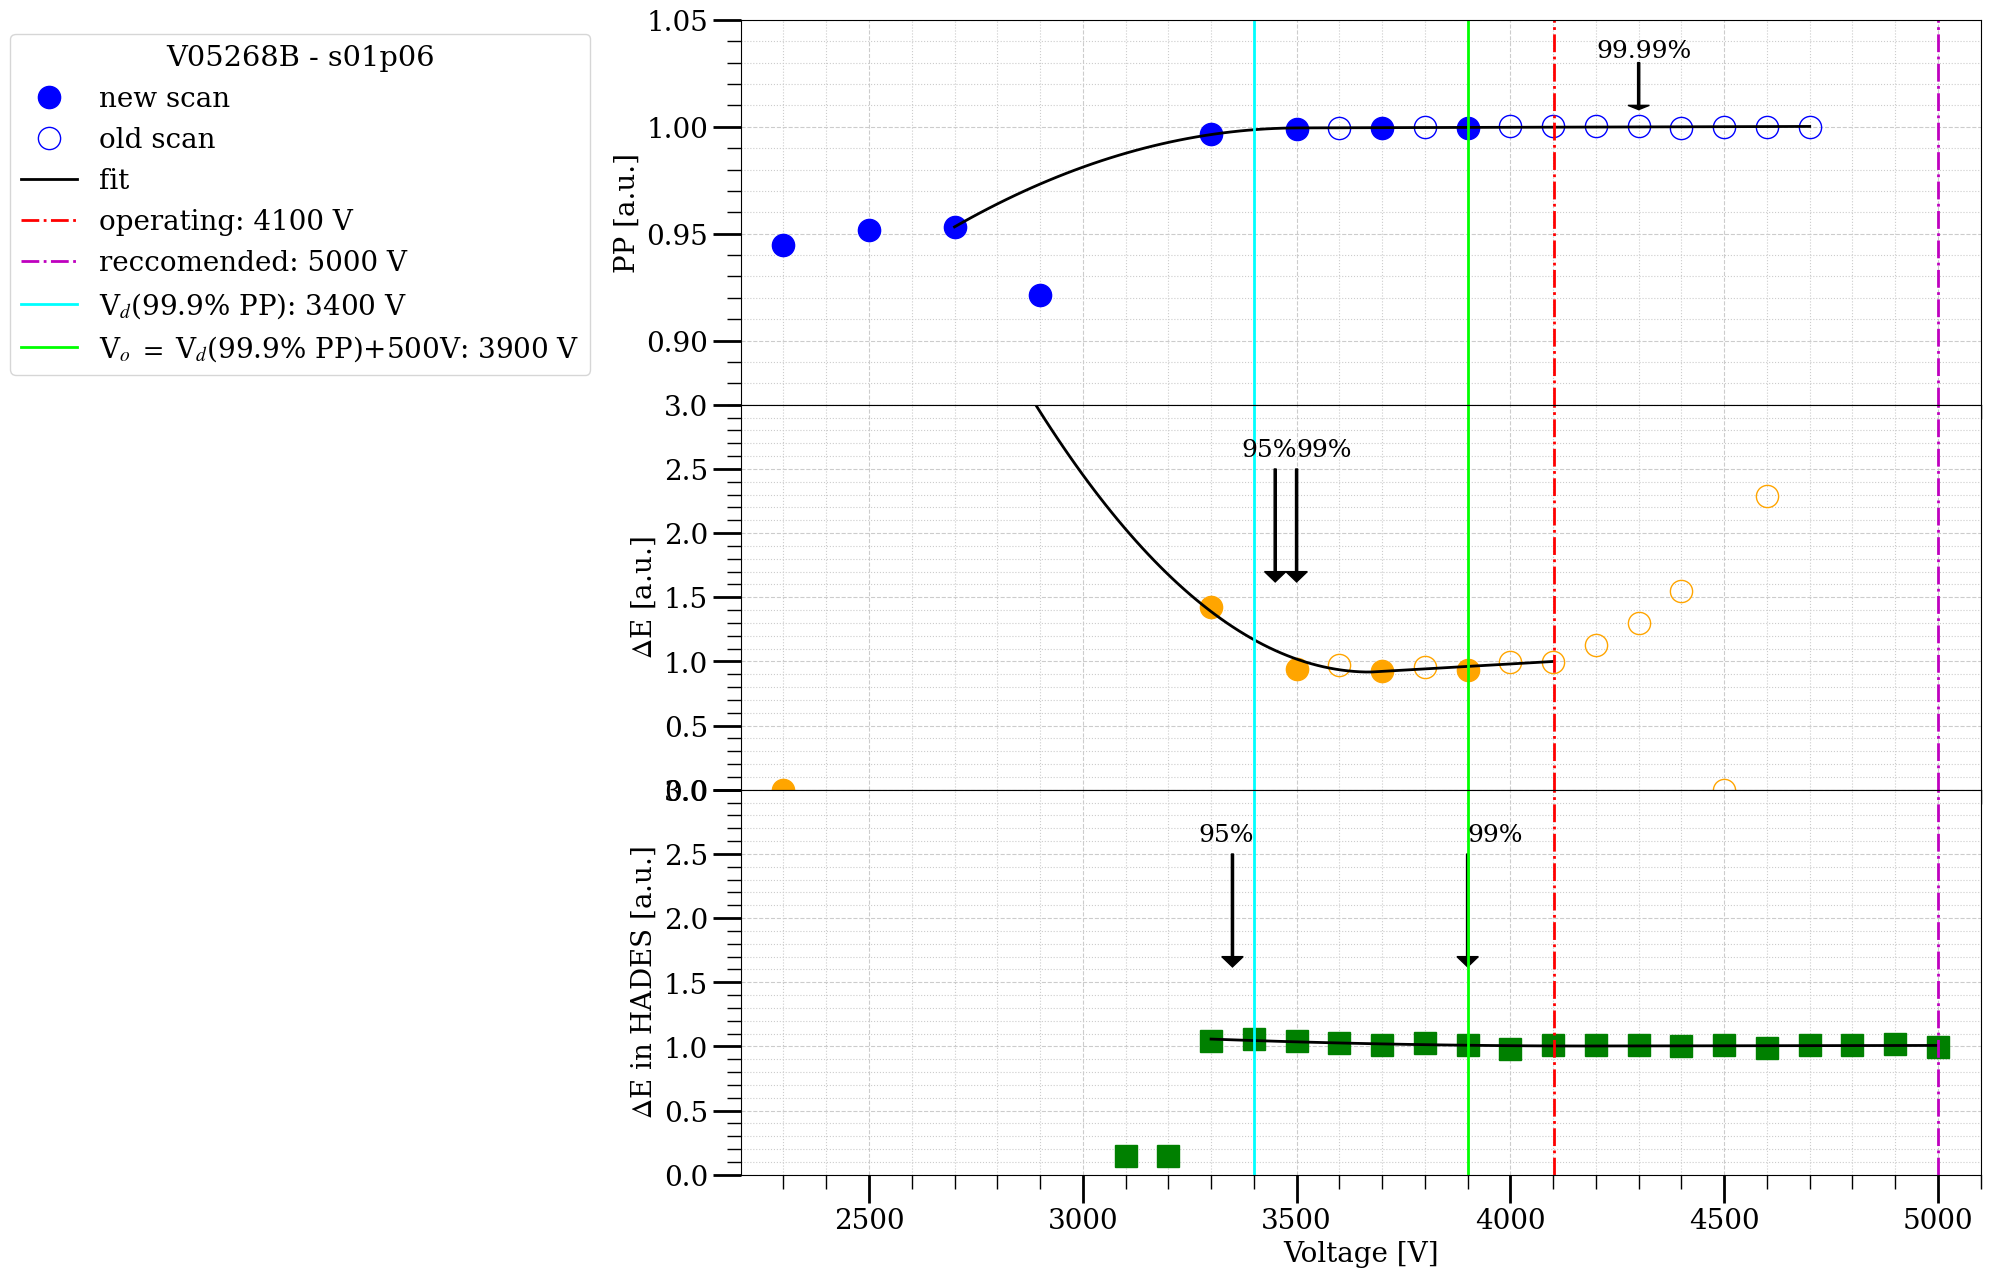

In [17]:
#comparison with new scan
with open(file_new, "r") as outfile: 
    scan_new = json.load(outfile)
    
voltages_new = np.array([int(v) for v in scan_new['voltages']]) 
peak_pos_FEP_new = np.array([float(v) for v in scan_new['peak_pos']]) 
peak_fwhm_FEP_new = np.array([float(v) for v in scan_new['peak_fwhm']]) 
pulser_pos_new = np.array([float(v) for v in scan_new['puls_pos']]) 
discharges_rate_new = np.array([float(v) for v in scan_new['rate_discharges']]) 


#comparison with old scan
with open(file_old, "r") as outfile: 
    scan_old = json.load(outfile)
    
voltages_old = np.array([int(v) for v in scan_old['voltages']]) 
peak_pos_FEP_old = np.array([float(v) for v in scan_old['peak_pos']]) 
peak_fwhm_FEP_old = np.array([float(v) for v in scan_old['peak_fwhm']]) 
pulser_pos_old = np.array([float(v) for v in scan_old['puls_pos']]) 
discharges_rate_old = np.array([float(v) for v in scan_old['rate_discharges']]) 

#compare with Co60 HADES characterization
voltages_Co60 = []
peak_fwhm_Co60 = []

with open(file_Co60, "r") as csv_file: 
    csv_reader = csv.DictReader(csv_file)
    for row in csv_reader:
        voltages_Co60.append(int(row['opV']))
        peak_fwhm_Co60.append(float(row['fwhm_co60fep']))
voltages_Co60=np.array(voltages_Co60)
peak_fwhm_Co60=np.array(peak_fwhm_Co60)


if reccomended in voltages_old :
    best_voltage=reccomended
else:
    best_voltage=max(voltages_old)
best_peak = peak_pos_FEP_old[voltages_old==best_voltage]
best_fwhm = peak_fwhm_FEP_old[voltages_old==4100]#best_voltage]
best_fwhm_Co60 = peak_fwhm_Co60[voltages_Co60==reccomended]
print(best_peak)

fig, axis = plt.subplots(3, figsize=(16,15), sharex='col',gridspec_kw={'hspace': 0, 'wspace': 0})

min_voltage=min(list([min(voltages_new), min(voltages_old), min(voltages_Co60)]))
max_voltage=max(list([max(voltages_new), max(voltages_old), max(voltages_Co60)]))

mask_peak_new = (peak_pos_FEP_new>15000) #(peak_pos_FEP>0)#15500)
mask_peak_old = (peak_pos_FEP_old>15000) #(peak_pos_FEP_old>0)#15500)

axis[0].plot(voltages_new[mask_peak_new],peak_pos_FEP_new[mask_peak_new]/best_peak,'b:',marker='o',ms=16,ls='none', label='new scan')
axis[0].plot(voltages_old[mask_peak_old],peak_pos_FEP_old[mask_peak_old]/best_peak,'b:',marker='o',ms=16, ls='none',markerfacecolor='none', label='old scan')


peak_pos_tot = np.array(list(peak_pos_FEP_new[mask_peak_new])+ list(peak_pos_FEP_old[mask_peak_old]))
voltages_tot = np.array(list(voltages_new[mask_peak_new])+ list(voltages_old[mask_peak_old]))
norm_peak = (peak_pos_tot/best_peak)
mask_fit = (norm_peak>0.76)  & (voltages_tot!=2900) & (voltages_tot>2600)
x0 = 4500 #min(voltages_tot[(norm_peak>0.999)])
my_guess= [x0,1,1,1]
popt, pcov = curve_fit(quad_plateau, voltages_tot[mask_fit], norm_peak[mask_fit], p0=my_guess)
xn = np.linspace(min(voltages_tot[mask_fit]),max(voltages_tot[mask_fit]),100)
yn =  quad_plateau( xn, *popt )
pp_999=np.interp(0.999, yn,xn)
pp_9999=np.interp(0.9999, yn,xn)
print("pp_999", pp_999)
print("pp_9999", pp_9999)
pp_999=3400
pp_9999=4300
axis[0].arrow(pp_9999, 1.03, 0.0, -0.02, width = 5, head_width = 50,  head_length = 0.002, fc ='k', ec ='k')
axis[0].text(pp_9999-100, 1.03+0.0025, "99.99%", fontsize=18)
axis[0].plot(xn, yn, color='black', label='fit', linewidth=2)
axis[0].set_ylim(0.87,1.05)
axis[0].set_ylabel('PP [a.u.]')


peak_fwhm_tot = np.array(list(peak_fwhm_FEP_new[mask_peak_new])+ list(peak_fwhm_FEP_old[mask_peak_old]))
norm_peak_fwhm = (peak_fwhm_tot/best_fwhm)
mask_fit_fwhm = (norm_peak_fwhm>-0.76)  & (voltages_tot!=2900) & (voltages_tot>2600) &  (voltages_tot<4200)
x0_fwhm = 4500 #min(voltages_tot[(norm_peak_fwhm>0.99)])
my_guess_fwhm = [x0_fwhm,1,1,1]
popt_fwhm, pcov_fwhm = curve_fit(quad_plateau, voltages_tot[mask_fit_fwhm], norm_peak_fwhm[mask_fit_fwhm], p0=my_guess_fwhm)
xn_fwhm = np.linspace(min(voltages_tot[mask_fit_fwhm]),max(voltages_tot[mask_fit_fwhm]),100)
yn_fwhm =  quad_plateau( xn_fwhm, *popt_fwhm )
#normalization on the fit at reccomended
new_best_fwhm = np.interp(reccomended, xn_fwhm,yn_fwhm)
print(new_best_fwhm)
new_norm_peak_fwhm  = norm_peak_fwhm/new_best_fwhm
popt_fwhm, pcov_fwhm = curve_fit(quad_plateau, voltages_tot[mask_fit_fwhm], new_norm_peak_fwhm[mask_fit_fwhm], p0=my_guess_fwhm)
xn_fwhm = np.linspace(min(voltages_tot[mask_fit_fwhm]),max(voltages_tot[mask_fit_fwhm]),100)
yn_fwhm =  quad_plateau( xn_fwhm, *popt_fwhm )
yn_fwhm_r=yn_fwhm*-1
fwhm_95=np.interp(-1.05, yn_fwhm_r,xn_fwhm)
fwhm_99=np.interp(-1.01, yn_fwhm_r,xn_fwhm)
print("fwhm_95", fwhm_95)
print("fwhm_99", fwhm_99)
fwhm_95=3450
fwhm_99=3500
axis[1].plot(voltages_new[mask_peak_new],peak_fwhm_FEP_new[mask_peak_new]/best_fwhm/new_best_fwhm,color='orange',marker='o',ms=16, ls='none')
axis[1].plot(voltages_old[mask_peak_old],peak_fwhm_FEP_old[mask_peak_old]/best_fwhm/new_best_fwhm,color='orange',marker='o',ms=16, markerfacecolor='none', ls='none')
axis[1].arrow(fwhm_95, y_arrow, 0.0, dy_arrow, width = 5, head_width = 50,  head_length = head_length, fc ='k', ec ='k')
axis[1].text(fwhm_95+dx_fwhm_95_text, dy_fwhm_text, "95%", fontsize=18)
axis[1].arrow(fwhm_99, y_arrow, 0.0, dy_arrow, width = 5, head_width = 50,  head_length = head_length, fc ='k', ec ='k')
axis[1].text(fwhm_99+dx_fwhm_99_text, dy_fwhm_text, "99%", fontsize=18)
axis[1].plot(xn_fwhm, yn_fwhm, color='black', linewidth=2)
axis[1].set_ylim(y_down,y_up)
axis[1].set_ylabel('$\Delta$E [a.u.]')


norm_peak_Co60_fwhm = (peak_fwhm_Co60/best_fwhm_Co60)
mask_fit_Co60_fwhm = (norm_peak_Co60_fwhm<3.5)  & (voltages_Co60>3200) #& (voltages_Co60!=31000) & (voltages_Co60!=3000)
print(voltages_Co60[mask_fit_Co60_fwhm])
x0_Co60_fwhm = max(voltages_Co60[(norm_peak_Co60_fwhm<3.95)])
my_guess_Co60_fwhm = [x0_Co60_fwhm,1,1,1]
popt_fwhm_Co60, pcov_fwhm_Co60 = curve_fit(quad_plateau, voltages_Co60[mask_fit_Co60_fwhm], norm_peak_Co60_fwhm[mask_fit_Co60_fwhm], p0=my_guess_Co60_fwhm)
xn_Co60_fwhm = np.linspace(min(voltages_Co60[mask_fit_Co60_fwhm]),max(voltages_Co60[mask_fit_Co60_fwhm]),100)
yn_Co60_fwhm =  quad_plateau( xn_Co60_fwhm, *popt_fwhm_Co60 )
#normalization on the fit at reccomended
new_best_fwhm_Co60 = np.interp(reccomended, xn_Co60_fwhm,yn_Co60_fwhm)
print(best_fwhm_Co60)
print(new_best_fwhm_Co60)
#axis[2].plot(xn_Co60_fwhm, yn_Co60_fwhm, color='black', linewidth=2)
new_norm_peak_Co60_fwhm  = norm_peak_Co60_fwhm/new_best_fwhm_Co60
popt_fwhm_Co60, pcov_fwhm_Co60 = curve_fit(quad_plateau, voltages_Co60[mask_fit_Co60_fwhm], new_norm_peak_Co60_fwhm[mask_fit_Co60_fwhm], p0=my_guess_fwhm)
xn_Co60_fwhm = np.linspace(min(voltages_Co60[mask_fit_Co60_fwhm]),max(voltages_Co60[mask_fit_Co60_fwhm]),100)
yn_Co60_fwhm =  quad_plateau( xn_Co60_fwhm, *popt_fwhm_Co60 )
yn_Co60_fwhm_r = yn_Co60_fwhm*-1
fwhm_Co60_95=np.interp(-1.05, yn_Co60_fwhm_r,xn_Co60_fwhm)
fwhm_Co60_99=np.interp(-1.01, yn_Co60_fwhm_r,xn_Co60_fwhm)
print("fwhm_Co60_95", fwhm_Co60_95)
print("fwhm_Co60_99", fwhm_Co60_99)
fwhm_Co60_95 = 3350
fwhm_Co60_99 = 3900
axis[2].plot(voltages_Co60, new_norm_peak_Co60_fwhm,'g:',marker='s',ms=16,ls='none')
axis[2].arrow(fwhm_Co60_95, y_arrow, 0.0, dy_arrow, width = 5, head_width = 50,  head_length = head_length, fc ='k', ec ='k')
axis[2].text(fwhm_Co60_95+dx_fwhm_95_text, dy_fwhm_text, "95%", fontsize=18)
axis[2].arrow(fwhm_Co60_99, y_arrow, 0.0, dy_arrow, width = 5, head_width = 50,  head_length = head_length, fc ='k', ec ='k')
axis[2].text(fwhm_Co60_99+dx_fwhm_99_text,dy_fwhm_text, "99%", fontsize=18)
axis[2].plot(xn_Co60_fwhm, yn_Co60_fwhm, color='black', linewidth=2)
axis[2].set_ylim(y_down,y_up)
axis[2].set_ylabel('$\Delta$E in HADES [a.u.]')
axis[2].set_xlabel('Voltage [V]')

if zoom:
    axis[1].axhline(1.01,c='m',ls='-.',lw=2)
    axis[1].axhline(1.05,c='m',ls='-.',lw=2)
    axis[2].axhline(1.01,c='m',ls='-.',lw=2)
    axis[2].axhline(1.05,c='m',ls='-.',lw=2)

for ax in axis:
    ax.set_xlim(min_voltage-100,max_voltage+100)
    ax.axvline(operating+1,c='r',ls='-.',lw=2,label=f'operating: {operating:.0f} V')
    ax.axvline(reccomended,c='m',ls='-.',lw=2,label=f'reccomended: {reccomended:.0f} V')
    ax.axvline(pp_999,c='cyan',ls='-',lw=2, label=f'V$_d$(99.9% PP): {pp_999:.0f} V')
    ax.axvline(pp_999+500,c='lime',ls='-',lw=2, label=f'V$_o$ $=$ V$_d$(99.9% PP)+500V: {pp_999+500:.0f} V')
    ax.yaxis.set_minor_locator(AutoMinorLocator(10))
    ax.xaxis.set_minor_locator(AutoMinorLocator(10))
    ax.minorticks_on()
    ax.tick_params('both', length=20, width=2, which='major')
    ax.tick_params('both', length=10, width=1, which='minor')
    ax.grid(which='major', color='#CCCCCC', linestyle='--')
    ax.grid(which='minor', color='#CCCCCC', linestyle=':')

axis[0].legend(title=f'{detectors[n_det]} - s{string:02}p{position:02}',bbox_to_anchor=(-0.11, 1.0))

In [16]:
#comparison with new scan
with open(file_new, "r") as outfile: 
    scan_new = json.load(outfile)
    
voltages_new = np.array([int(v) for v in scan_new['voltages']]) 
peak_pos_FEP_new = np.array([float(v) for v in scan_new['peak_pos']]) 
peak_fwhm_FEP_new = np.array([float(v) for v in scan_new['peak_fwhm']]) 
pulser_pos_new = np.array([float(v) for v in scan_new['puls_pos']]) 
discharges_rate_new = np.array([float(v) for v in scan_new['rate_discharges']]) 

'''
#comparison with old scan
with open(file_old, "r") as outfile: 
    scan_old = json.load(outfile)
    
voltages_old = np.array([int(v) for v in scan_old['voltages']]) 
peak_pos_FEP_old = np.array([float(v) for v in scan_old['peak_pos']]) 
peak_fwhm_FEP_old = np.array([float(v) for v in scan_old['peak_fwhm']]) 
pulser_pos_old = np.array([float(v) for v in scan_old['puls_pos']]) 
discharges_rate_old = np.array([float(v) for v in scan_old['rate_discharges']]) 

print(peak_pos_FEP_new)
print(peak_pos_FEP_old)
'''

#compare with Co60 HADES characterization
voltages_Co60 = []
peak_fwhm_Co60 = []
peak_pos_Co60 = []

with open(file_Co60, "r") as csv_file: 
    csv_reader = csv.DictReader(csv_file)
    for row in csv_reader:
        voltages_Co60.append(int(row['opV']))
        peak_fwhm_Co60.append(float(row['fwhm_co60fep']))
        if detectors[n_det]=="V05267B":
            peak_pos_Co60_keV=float(row['pp_co60fep'])
            acal_Co60=float(row['a'])
            bcal_Co60=float(row['b'])
            ccal_Co60=float(row['c'])
            peak_pos_Co60.append((peak_pos_Co60_keV*peak_pos_Co60_keV-acal_Co60)/bcal_Co60)

voltages_Co60=np.array(voltages_Co60)
peak_fwhm_Co60=np.array(peak_fwhm_Co60)
peak_pos_Co60=np.array(peak_pos_Co60)
print(peak_pos_Co60)

if reccomended in voltages_new :
    best_voltage=reccomended
else:
    best_voltage=max(voltages_new)
best_peak = peak_pos_FEP_new[voltages_new==best_voltage]
best_fwhm = peak_fwhm_FEP_new[voltages_new==best_voltage]
best_fwhm_Co60 = peak_fwhm_Co60[voltages_Co60==reccomended]
best_pos_Co60 = peak_pos_Co60[voltages_Co60==reccomended]
print(best_peak)

fig, axis = plt.subplots(4, figsize=(16,15), sharex='col',gridspec_kw={'hspace': 0, 'wspace': 0})

min_voltage=min(list([min(voltages_new), min(voltages_Co60)]))
max_voltage=max(list([max(voltages_new), max(voltages_Co60)]))

mask_peak_new = (peak_pos_FEP_new>10500) #(peak_pos_FEP>0)#15500)
#mask_peak_old = (peak_pos_FEP_old>15500) #(peak_pos_FEP_old>0)#15500)

axis[0].plot(voltages_new[mask_peak_new],peak_pos_FEP_new[mask_peak_new]/best_peak,'b:',marker='o',ms=16,ls='none', label='new scan')
#axis[0].plot(voltages_old[mask_peak_old],peak_pos_FEP_old[mask_peak_old]/best_peak,'b:',marker='o',ms=16, ls='none',markerfacecolor='none', label='old scan')


peak_pos_tot = np.array(list(peak_pos_FEP_new[mask_peak_new]))#+ list(peak_pos_FEP_old[mask_peak_old]))
voltages_tot = np.array(list(voltages_new[mask_peak_new]))#+ list(voltages_old[mask_peak_old]))
norm_peak = (peak_pos_tot/best_peak)
mask_fit = (norm_peak>-0.46)
x0 = 2500 #min(voltages_tot[(norm_peak>0.999)])
my_guess= [x0,1,1,1]
popt, pcov = curve_fit(quad_plateau, voltages_tot[mask_fit], norm_peak[mask_fit], p0=my_guess)
xn = np.linspace(min(voltages_tot[mask_fit]),max(voltages_tot[mask_fit]),100)
yn =  quad_plateau( xn, *popt )
pp_999=np.interp(0.999, yn,xn)
pp_9999=np.interp(0.9999, yn,xn)
print("pp_999", pp_999)
print("pp_9999", pp_9999)
pp_999=4250
pp_9999=4350
#axis[0].arrow(pp_9999, 1.015, 0.0, -0.01, width = 5, head_width = 50,  head_length = 0.002, fc ='k', ec ='k')
#axis[0].text(pp_9999-100, 1.015+0.002, "99.99%", fontsize=18)
#axis[0].plot(xn, yn, color='black', label='fit', linewidth=2)
axis[0].set_ylim(0.94,1.2)
axis[0].set_ylabel('PP [a.u.]')


peak_fwhm_tot = np.array(list(peak_fwhm_FEP_new[mask_peak_new]))#+ list(peak_fwhm_FEP_old[mask_peak_old]))
norm_peak_fwhm = (peak_fwhm_tot/best_fwhm)
mask_fit_fwhm = (norm_peak_fwhm>-0.56) # & (voltages_tot>2800) # & (voltages_tot!=4600)
x0_fwhm = 4500 #min(voltages_tot[(norm_peak_fwhm>0.99)])
my_guess_fwhm = [x0_fwhm,1,1,1]
popt_fwhm, pcov_fwhm = curve_fit(quad_plateau, voltages_tot[mask_fit_fwhm], norm_peak_fwhm[mask_fit_fwhm], p0=my_guess_fwhm)
xn_fwhm = np.linspace(min(voltages_tot[mask_fit_fwhm]),max(voltages_tot[mask_fit_fwhm]),100)
yn_fwhm =  quad_plateau( xn_fwhm, *popt_fwhm )
#normalization on the fit at reccomended
new_best_fwhm = np.interp(reccomended, xn_fwhm,yn_fwhm)
print(new_best_fwhm)
new_norm_peak_fwhm  = norm_peak_fwhm/new_best_fwhm
popt_fwhm, pcov_fwhm = curve_fit(quad_plateau, voltages_tot[mask_fit_fwhm], new_norm_peak_fwhm[mask_fit_fwhm], p0=my_guess_fwhm)
xn_fwhm = np.linspace(min(voltages_tot[mask_fit_fwhm]),max(voltages_tot[mask_fit_fwhm]),100)
yn_fwhm =  quad_plateau( xn_fwhm, *popt_fwhm )
yn_fwhm_r=yn_fwhm*-1
fwhm_95=np.interp(-1.05, yn_fwhm_r,xn_fwhm)
fwhm_99=np.interp(-1.01, yn_fwhm_r,xn_fwhm)
print("fwhm_95", fwhm_95)
print("fwhm_99", fwhm_99)
fwhm_95=4200
fwhm_99=4300
axis[1].plot(voltages_new[mask_peak_new],peak_fwhm_FEP_new[mask_peak_new]/best_fwhm/new_best_fwhm,color='orange',marker='o',ms=16, ls='none')
#axis[1].plot(voltages_old[mask_peak_old],peak_fwhm_FEP_old[mask_peak_old]/best_fwhm/new_best_fwhm,color='orange',marker='o',ms=16, markerfacecolor='none', ls='none')
#axis[1].arrow(fwhm_95, y_arrow, 0.0, dy_arrow, width = 5, head_width = 50,  head_length = head_length, fc ='k', ec ='k')
#axis[1].text(fwhm_95+dx_fwhm_95_text, dy_fwhm_text, "95%", fontsize=18)
#axis[1].arrow(fwhm_99, y_arrow, 0.0, dy_arrow, width = 5, head_width = 50,  head_length = head_length, fc ='k', ec ='k')
#axis[1].text(fwhm_99+dx_fwhm_95_text, dy_fwhm_text, "99%", fontsize=18)
#axis[1].plot(xn_fwhm, yn_fwhm, color='black', linewidth=2)
axis[1].set_ylim(y_down,y_up)
axis[1].set_ylabel('$\Delta$E [a.u.]')


norm_peak_Co60_fwhm = (peak_fwhm_Co60/best_fwhm_Co60)
mask_fit_Co60_fwhm = (norm_peak_Co60_fwhm<3.5)  #& (voltages_Co60!=4300) & (voltages_Co60!=31000) & (voltages_Co60!=3000)
print(voltages_Co60[mask_fit_Co60_fwhm])
x0_Co60_fwhm = max(voltages_Co60[(norm_peak_Co60_fwhm<3.95)])
my_guess_Co60_fwhm = [x0_Co60_fwhm,1,1,1]
popt_fwhm_Co60, pcov_fwhm_Co60 = curve_fit(quad_plateau, voltages_Co60[mask_fit_Co60_fwhm], norm_peak_Co60_fwhm[mask_fit_Co60_fwhm], p0=my_guess_Co60_fwhm)
xn_Co60_fwhm = np.linspace(min(voltages_Co60[mask_fit_Co60_fwhm]),max(voltages_Co60[mask_fit_Co60_fwhm]),100)
yn_Co60_fwhm =  quad_plateau( xn_Co60_fwhm, *popt_fwhm_Co60 )
#normalization on the fit at reccomended
new_best_fwhm_Co60 = np.interp(reccomended, xn_Co60_fwhm,yn_Co60_fwhm)
print(best_fwhm_Co60)
print(new_best_fwhm_Co60)
#axis[2].plot(xn_Co60_fwhm, yn_Co60_fwhm, color='black', linewidth=2)
new_norm_peak_Co60_fwhm  = norm_peak_Co60_fwhm/new_best_fwhm_Co60
popt_fwhm_Co60, pcov_fwhm_Co60 = curve_fit(quad_plateau, voltages_Co60[mask_fit_Co60_fwhm], new_norm_peak_Co60_fwhm[mask_fit_Co60_fwhm], p0=my_guess_fwhm)
xn_Co60_fwhm = np.linspace(min(voltages_Co60[mask_fit_Co60_fwhm]),max(voltages_Co60[mask_fit_Co60_fwhm]),100)
yn_Co60_fwhm =  quad_plateau( xn_Co60_fwhm, *popt_fwhm_Co60 )
yn_Co60_fwhm_r = yn_Co60_fwhm*-1
fwhm_Co60_95=np.interp(-1.05, yn_Co60_fwhm_r,xn_Co60_fwhm)
fwhm_Co60_99=np.interp(-1.01, yn_Co60_fwhm_r,xn_Co60_fwhm)
print("fwhm_Co60_95", fwhm_Co60_95)
print("fwhm_Co60_99", fwhm_Co60_99)
fwhm_Co60_95 = 4200
fwhm_Co60_99 = 4450
axis[2].plot(voltages_Co60, new_norm_peak_Co60_fwhm,'g:',marker='s',ms=16,ls='none')
axis[2].arrow(fwhm_Co60_95, y_arrow, 0.0, dy_arrow, width = 5, head_width = 50,  head_length = head_length, fc ='k', ec ='k')
axis[2].text(fwhm_Co60_95+dx_fwhm_95_text, dy_fwhm_text, "95%", fontsize=18)
axis[2].arrow(fwhm_Co60_99, y_arrow, 0.0, dy_arrow, width = 5, head_width = 50,  head_length = head_length, fc ='k', ec ='k')
axis[2].text(fwhm_Co60_99+dx_fwhm_99_text,dy_fwhm_text, "99%", fontsize=18)
axis[2].plot(xn_Co60_fwhm, yn_Co60_fwhm, color='black', linewidth=2)
axis[2].set_ylim(y_down,y_up)
axis[2].set_ylabel('$\Delta$E in HADES [a.u.]')
axis[2].set_xlabel('Voltage [V]')

norm_peak_pos_Co60 = (peak_pos_Co60/best_pos_Co60)
mask_peak_pos_Co60 = (peak_pos_Co60>3.5)  #& (voltages_Co60!=4300) & (voltages_Co60!=31000) & (voltages_Co60!=3000)
#x0_Co60_fwhm = max(voltages_Co60[(norm_peak_Co60_fwhm<3.95)])
my_guess_Co60_pos = [4000,1,1,1]
popt_pos_Co60, pcov_fwhm_Co60 = curve_fit(quad_plateau, voltages_Co60[mask_peak_pos_Co60], norm_peak_pos_Co60[mask_peak_pos_Co60], p0=my_guess_Co60_pos)
xn_Co60_pos = np.linspace(min(voltages_Co60[mask_peak_pos_Co60]),max(voltages_Co60[mask_peak_pos_Co60]),100)
yn_Co60_pos =  quad_plateau( xn_Co60_pos, *popt_pos_Co60 )
#normalization on the fit at reccomended
new_best_pos_Co60 = np.interp(reccomended, xn_Co60_pos,yn_Co60_pos)
#print(best_fwhm_Co60)
#print(new_best_fwhm_Co60)
#axis[2].plot(xn_Co60_fwhm, yn_Co60_fwhm, color='black', linewidth=2)
new_norm_peak_pos_Co60  = norm_peak_pos_Co60/new_best_pos_Co60
popt_pos_Co60, pcov_fwhm_Co60 = curve_fit(quad_plateau, voltages_Co60[mask_peak_pos_Co60], new_norm_peak_pos_Co60[mask_peak_pos_Co60], p0=my_guess_Co60_pos)
xn_Co60_pos = np.linspace(min(voltages_Co60[mask_peak_pos_Co60]),max(voltages_Co60[mask_peak_pos_Co60]),100)
yn_Co60_pos =  quad_plateau( xn_Co60_pos, *popt_pos_Co60 )
yn_Co60_pos_r = yn_Co60_pos*-1
pos_Co60_95=np.interp(-1.05, yn_Co60_pos_r,xn_Co60_pos)
pos_Co60_99=np.interp(-1.01, yn_Co60_pos_r,xn_Co60_pos)
print("pos_Co60_95", pos_Co60_95)
print("pos_Co60_99", pos_Co60_99)
pos_Co60_95 = 3300
pos_Co60_99 = 3300
axis[3].plot(voltages_Co60, new_norm_peak_pos_Co60,'g:',marker='s',ms=16,ls='none')
axis[3].arrow(pos_Co60_95, 1.02, 0.0, -0.015, width = 5, head_width = 50,  head_length = 0.002, fc ='k', ec ='k')
axis[3].text(pos_Co60_95+dx_fwhm_95_text, 1.02+0.005, "95%", fontsize=18)
axis[3].arrow(pos_Co60_99, 1.02, 0.0, -0.015, width = 5, head_width = 50,  head_length = 0.002, fc ='k', ec ='k')
axis[3].text(pos_Co60_99+dx_fwhm_99_text,1.02+0.005, "99%", fontsize=18)
axis[3].plot(xn_Co60_pos, yn_Co60_pos, color='black', linewidth=2)
axis[3].set_ylim(0.97,1.03)
axis[3].set_ylabel('PP in HADES [a.u.]')
axis[3].set_xlabel('Voltage [V]')

if zoom:
    axis[1].axhline(1.01,c='m',ls='-.',lw=2)
    axis[1].axhline(1.05,c='m',ls='-.',lw=2)
    axis[2].axhline(1.01,c='m',ls='-.',lw=2)
    axis[2].axhline(1.05,c='m',ls='-.',lw=2)

for ax in axis:
    ax.set_xlim(min_voltage-100,max_voltage+100)
    ax.axvline(operating+1,c='r',ls='-.',lw=2,label=f'operating: {operating:.0f} V')
    ax.axvline(reccomended,c='m',ls='-.',lw=2,label=f'reccomended: {reccomended:.0f} V')
    ax.axvline(fwhm_Co60_95,c='cyan',ls='-',lw=2, label=f'V$_d$(95% $\Delta$E): {fwhm_Co60_95:.0f} V')
    ax.axvline(fwhm_Co60_95+500,c='lime',ls='-',lw=2, label=f'V$_o$ $=$ V$_d$(95% $\Delta$E)+500V: {fwhm_Co60_95+500:.0f} V')
    ax.yaxis.set_minor_locator(AutoMinorLocator(10))
    ax.xaxis.set_minor_locator(AutoMinorLocator(10))
    ax.minorticks_on()
    ax.tick_params('both', length=20, width=2, which='major')
    ax.tick_params('both', length=10, width=1, which='minor')
    ax.grid(which='major', color='#CCCCCC', linestyle='--')
    ax.grid(which='minor', color='#CCCCCC', linestyle=':')

axis[0].legend(title=f'{detectors[n_det]} - s{string:02}p{position:02}',bbox_to_anchor=(-0.11, 1.0))

[]


IndexError: boolean index did not match indexed array along dimension 0; dimension is 0 but corresponding boolean dimension is 21